# Imports

In [1]:
from ase import Atoms

In [2]:
from ase.build import bulk

In [3]:
from ase.calculators.morse import MorsePotential

In [4]:
from pyiron_contrib.tinybase.task import FunctionTask, SeriesTask

/home/ponder/science/phd/dev/contrib/pyiron_contrib/__init__.py:9: UserWarning: pyiron module not found, importing Project from pyiron_base
  warnings.warn("pyiron module not found, importing Project from pyiron_base")


In [5]:
from pyiron_contrib.tinybase.ase import AseStaticTask, AseMDTask, AseMinimizeTask

In [6]:
import numpy as np

In [7]:
from pyiron_contrib.tinybase.murn import MurnaghanTask

In [8]:
from pyiron_contrib.tinybase.executor import FuturesSubmitter, Submitter

In [9]:
from concurrent.futures import ThreadPoolExecutor

In [10]:
from concurrent.futures import ProcessPoolExecutor

In [11]:
make_process = lambda n: FuturesSubmitter(ProcessPoolExecutor(max_workers=n))

In [12]:
from pympipool import PoolExecutor

In [13]:
process = make_process(4)
thread = FuturesSubmitter(ThreadPoolExecutor(max_workers=4))

In [14]:
process = FuturesSubmitter(PoolExecutor(4))

In [15]:
import logging
logging.getLogger().setLevel(20)

# Simple ASE Static Calculation

In [16]:
a = AseStaticTask()

In [17]:
a.input.structure = bulk("Fe")

In [18]:
a.input.calculator = MorsePotential()

In [19]:
ret, output = a.execute(); ret, output

(ReturnStatus(Code.DONE, None),
 EnergyPotOutput(energy_pot=-0.00013307075712109978))

# ASE MD

In [20]:
md = AseMDTask(capture_exceptions=False)

In [21]:
md.input.structure = bulk("Fe", a=1.2, cubic=True).repeat(3)
md.input.calculator = MorsePotential()

In [22]:
md.input.steps = 100
md.input.timestep = 3.0
md.input.temperature = 600.0
md.input.output_steps = 20

In [23]:
%%time
status, output = md.execute()

CPU times: user 30.4 s, sys: 1min 34s, total: 2min 4s
Wall time: 8.37 s


In [24]:
output.pot_energies

array([-303.20813268, -303.20813268, -299.50417176, -300.69291846,
       -300.88356067, -299.87440092, -300.56706777, -300.41201114,
       -300.53923815, -300.01925116, -300.52098807, -300.26017925,
       -299.78016937, -300.92936235, -300.34657506, -300.3104632 ,
       -300.78479057, -300.66513799, -301.17922564, -300.44390943,
       -300.40110099, -300.76322532])

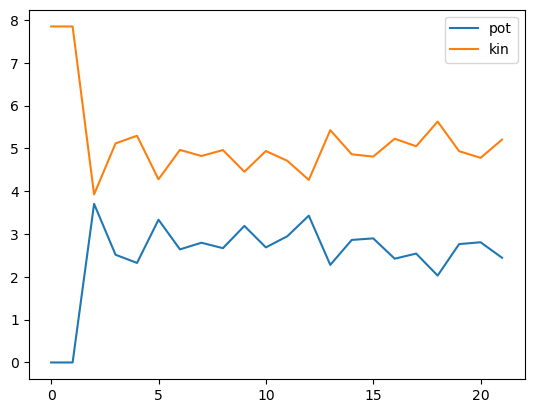

In [25]:
output.plot_energies()

In [26]:
output.animate_structures()

NGLWidget(max_frame=21)

# ASE Minimize

In [27]:
from pyiron_atomistics import ase_to_pyiron

In [28]:
mi = AseMinimizeTask()

In [29]:
dimer = Atoms(symbols=['Fe', 'Fe'], positions=[[0,0,0], [0,0, 1.2]], cell=[10,10,10])

In [30]:
mi.input.structure = dimer
mi.input.calculator = MorsePotential(rcut1=6,rcut2=10)

In [31]:
ase_to_pyiron(mi.input.structure).plot3d()

NGLWidget()

In [32]:
mi.input.max_steps = 100
mi.input.output_steps = 1
mi.input.ionic_force_tolerance = 1e-6

In [33]:
mi.input.lbfgs()

In [34]:
_, output = mi.execute()

       Step     Time          Energy         fmax
LBFGS:    0 00:07:16       -0.511670        2.5257
LBFGS:    1 00:07:16       -0.713127        2.9848
LBFGS:    2 00:07:16       -0.082483        0.4842
LBFGS:    3 00:07:16       -0.052236        0.3092
LBFGS:    4 00:07:16       -0.023154        0.1381
LBFGS:    5 00:07:16       -0.011968        0.0716
LBFGS:    6 00:07:16       -0.005874        0.0352
LBFGS:    7 00:07:16       -0.002950        0.0177
LBFGS:    8 00:07:16       -0.001470        0.0088
LBFGS:    9 00:07:16       -0.000735        0.0044
LBFGS:   10 00:07:16       -0.000368        0.0022
LBFGS:   11 00:07:16       -0.000184        0.0011
LBFGS:   12 00:07:16       -0.000092        0.0006
LBFGS:   13 00:07:16       -0.000046        0.0003
LBFGS:   14 00:07:16       -0.000023        0.0001
LBFGS:   15 00:07:16       -0.000011        0.0001
LBFGS:   16 00:07:16       -0.000006        0.0000
LBFGS:   17 00:07:16       -0.000003        0.0000
LBFGS:   18 00:07:16       -0.00

In [35]:
output.static_output()

StaticOutput(energy_kin=0.0, energy_pot=-8.972451867356014e-08)

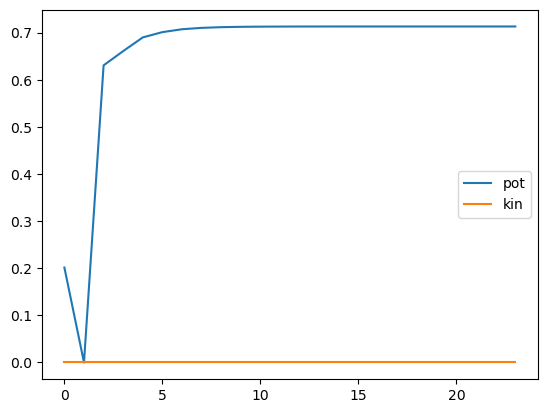

In [36]:
output.plot_energies()

In [37]:
abs(output.forces[-1]).max()

5.383470999656264e-07

In [38]:
output.animate_structures()

NGLWidget(max_frame=23)

# Murnaghan

## Basic

In [39]:
m = MurnaghanTask(capture_exceptions=False)

In [40]:
m.input.task = AseStaticTask(capture_exceptions=False)
m.input.task.input.calculator = MorsePotential()
m.input.structure = bulk("Fe", a=1.2)

In [41]:
m.input.task.input

AseStaticInput(structure=Sentinel(USERINPUT), calculator=<ase.calculators.morse.MorsePotential object at 0x7f44b02dd050>)

In [42]:
m.input.set_strain_range(.5, 15)

In [43]:
m.input.strains

array([0.79370053, 0.82982653, 0.86305437, 0.89390354, 0.92275884,
       0.94991425, 0.97559996, 1.        , 1.02326411, 1.04551592,
       1.06685884, 1.08738037, 1.10715524, 1.12624788, 1.14471424])

In [44]:
_, output = m.execute()

In [45]:
output

MurnaghanOutput(base_structure=Atoms(symbols='Fe', pbc=True, cell=[[-0.6, 0.6, 0.6], [0.6, -0.6, 0.6], [0.6, 0.6, -0.6]]), volumes=array([0.432     , 0.49371429, 0.55542857, 0.61714286, 0.67885714,
       0.74057143, 0.80228571, 0.864     , 0.92571429, 0.98742857,
       1.04914286, 1.11085714, 1.17257143, 1.23428571, 1.296     ]), energies=array([ 4.78924238, -2.02281605, -5.08315968, -6.30258662, -6.60273036,
       -6.44718724, -6.07592945, -5.61496542, -5.13100331, -4.65872214,
       -4.21510997, -3.8073844 , -3.43743364, -3.10432631, -2.80567942]))

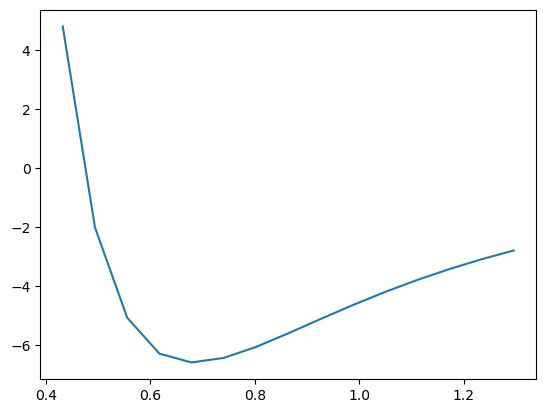

In [46]:
output.plot()

In [47]:
output.equilibrium_volume

0.6788605670604869

In [48]:
output.get_structure().get_volume()

0.6788605670604871

In [49]:
output.get_structure()

Atoms(symbols='Fe', pbc=True, cell=[[-0.553656237540387, 0.553656237540387, 0.553656237540387], [0.553656237540387, -0.553656237540387, 0.553656237540387], [0.553656237540387, 0.553656237540387, -0.553656237540387]])

## With an Executor

In [50]:
m = MurnaghanTask()

In [51]:
m.input.task = AseStaticTask()
m.input.task.input.calculator = MorsePotential()
m.input.structure = bulk("Fe", a=1.2)

In [52]:
m.input.task.input

AseStaticInput(structure=Sentinel(USERINPUT), calculator=<ase.calculators.morse.MorsePotential object at 0x7f44b032b910>)

In [53]:
m.input.set_strain_range(.6, 250)

In [54]:
%%time
exe = process.submit([m])
exe.run()
exe.wait()

CPU times: user 335 ms, sys: 257 ms, total: 591 ms
Wall time: 30.6 s


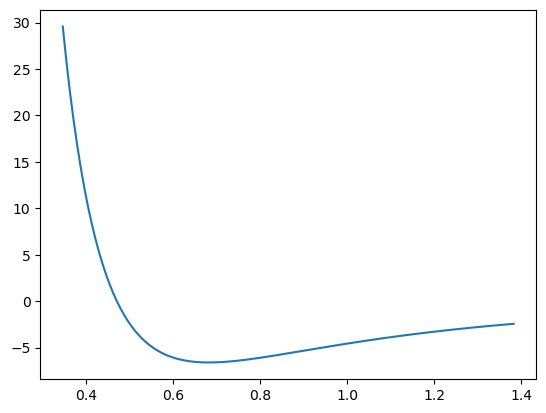

In [55]:
exe.output[0].plot()

# Combine Minimize and Murnaghan

In [56]:
m = MurnaghanTask(capture_exceptions=False)

In [57]:
mint = AseMinimizeTask(capture_exceptions=False)
mint.input.calculator = MorsePotential()
mint.input.max_steps = 100
mint.input.output_steps = 10
mint.input.ionic_force_tolerance = 1e-6
mint.input.lbfgs()

In [58]:
ser = mint.then(lambda output: output.static_output())

In [59]:
# ser.execute()

In [60]:
m.input.task = ser
m.input.structure = bulk("Fe", a=1.2)

In [61]:
m.input.set_strain_range(.5, 50)

In [62]:
%%time
exe = process.submit([m])
exe.run()
exe.wait()
output = exe.output[0]
ret = exe.status[0]

CPU times: user 1.64 s, sys: 618 ms, total: 2.25 s
Wall time: 1min 43s


In [63]:
output.energies[:10]

array([4.78924238, 4.51769267, 4.25194477, 3.99187529, 3.7373637 ,
       3.48829227, 3.244546  , 3.00601254, 2.77258214, 2.54414756])

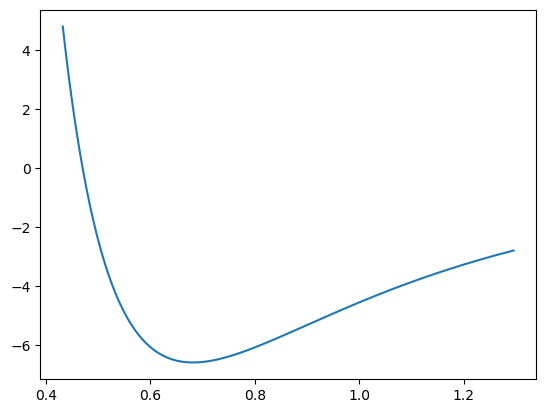

In [64]:
output.plot()

# Combine MD and Murnaghan

In [65]:
m = MurnaghanTask(capture_exceptions=False)

In [99]:
md = AseMDTask(capture_exceptions=False)
md.input.calculator = MorsePotential()
md.input.steps = 500
md.input.output_steps = 100
md.input.temperature = 300
md.input.timestep = 3

In [102]:
m.input.task = md.then(lambda output: output.static_output(how=output.Mean(0.5, 1.0)))

In [103]:
m.input.structure = bulk("Fe", cubic=True, a=1.2)

In [108]:
m.input.set_strain_range(.5, 50)

In [109]:
%%time
exe = process.submit([m])
exe.run()
exe.wait()
output = exe.output[0]
ret = exe.status[0]

KeyboardInterrupt: 

In [ ]:
output.energies[:10]

In [ ]:
output.plot()